In [2]:
import numpy as np
import pandas as pd
from TESStools import *
import os
import warnings
from multiprocessing import Pool, cpu_count
from scipy.stats import multivariate_normal
from tqdm.notebook import tqdm
import h5py as h5

In [3]:
cool_sgs = pd.read_csv('sample.csv',index_col=0)
cool_sgs

,RA,Dec,dist,pmRA,pmDec,Tmag,ContRatio,SpT,CommonName,MKType,...,SpecSource,Gal,w1mag,w2mag,w3mag,w4mag,RA_tic,Dec_tic,source_id,n_sectors
tic,,,,,,,,,,,,,,,,,,,,,
179437520,79.971947,-68.067692,0.091019,1.593040,0.205590,9.8540,NaN,RSG,SV* HV 2450,M1,...,N,LMC,6.841,6.993,6.134,4.754,79.971929,-68.067717,4658722752228316160,12
404965649,85.373961,-69.415872,0.060785,1.788260,0.708052,11.0373,NaN,RSG,CPD-69 502,NaN,...,N,LMC,8.013,8.161,7.247,5.391,85.374008,-69.415869,4657625263503324544,11
40185978,76.968537,-70.434641,0.160504,2.140400,0.216068,11.1070,NaN,RSG,SK -70 80,M0,...,N,LMC,8.254,8.398,8.099,7.782,76.968487,-70.434600,4652070290243179776,12
181445828,13.765720,-73.010260,0.236534,0.797799,-1.265550,11.0965,NaN,YSG,PMMR 74,G6Ia-Iab,...,N,SMC,8.741,8.825,8.492,8.396,NaN,NaN,4685961808462981248,1
182735393,15.655494,-72.273615,0.085619,0.942084,-1.163470,11.1242,NaN,YSG,PMMR 135,G6.5Ia-Iab,...,N,SMC,8.807,8.863,8.588,8.536,NaN,NaN,4687498998758427520,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182730317,16.205624,-72.106040,0.055346,0.664882,-1.272430,11.4480,NaN,YSG,RMC 36,B3:Iak,...,N,SMC,11.204,11.192,11.061,9.228,NaN,NaN,4687507584364583040,1
180792170,12.659946,-73.471738,0.058121,0.543531,-1.243180,11.1544,NaN,YSG,HD 5045,B2:I:,...,N,SMC,10.896,10.853,10.681,9.225,NaN,NaN,4685876050900042880,2
182905190,16.484663,-72.329100,0.057287,0.986675,-1.257930,11.6057,NaN,YSG,LHA 115-S 45,B1.5Ia:,...,N,SMC,11.192,11.145,10.694,7.014,NaN,NaN,4687488965713758336,2


# First things first, let's see how many SLFV components we need...

In [3]:
n_comps = []
slfv_init = h5.File('SLFV_init.hdf5', mode='w')
for tic,star in tqdm(cool_sgs.iterrows(), total=len(cool_sgs)):
    
    lc, lc_smooth = lc_extract(get_lc_from_id(tic), smooth=128)
    time, flux, err = lc['Time'], lc['Flux'], lc['Err']
    pseudo_NF = 0.5 / (np.mean(np.diff(time)))
    ls = LombScargle(time,flux,dy=err,)
    freq,power=ls.autopower(normalization='psd',maximum_frequency=pseudo_NF)
    power /= len(time)
    y_data = np.sqrt(power)
    
    #bic with a constant fit
    y_fit_const = np.mean(np.sqrt(power))
    rss_const = np.sum(np.power(np.log10(y_data) - np.log10(y_fit_const), 2.0))
    log_like_ish_const = len(freq)*np.log(rss_const/len(freq))
    old_bic = log_like_ish_const + (1.0)*np.log(len(freq))  
    
    popts = []
    pcovs = []
    popt, pcov, resid = fit_red_noise(freq, power)
    popts.append(popt)
    pcovs.append(pcov)
    
    #Calculate the BIC up to a constant: -2 log L + m log (N)
    y_fit = np.sum([noise_func(freq, *popt) for popt in popts],axis=0)
    
    rss = np.sum(np.power(np.log10(y_data) - np.log10(y_fit), 2.0))
    log_like_ish = len(freq)*np.log(rss/len(freq)) #sum of residuals squared
    
    resid_power = np.power(y_data - y_fit,2.0)
    
    bic = log_like_ish + 4.0*len(popts)*np.log(len(freq))
    
    bic_dif = bic - old_bic
    
    while bic_dif <= 0:
        old_bic = bic
        popt, pcov, resid = fit_red_noise(freq, resid_power)
        popts.append(popt)
        pcovs.append(pcov)
        
        y_fit = np.sum([noise_func(freq, *popt) for popt in popts],axis=0)
        
        rss = np.sum(np.power(np.log10(y_data) - np.log10(y_fit), 2.0))
        log_like_ish = len(freq)*np.log(rss/len(freq)) #sum of residuals squared
        
        residual_power = np.power(y_data - y_fit,2.0)
    
        bic = log_like_ish + 4.0*len(popts)*np.log(len(freq))
        
        bic_dif = bic - old_bic
    
    if len(popts) == 1:
        n_comp = 0
    else:
        popts = popts[:-1]
        pcovs = pcovs[:-1]
        n_comp = len(popts)
    
    n_comps.append(n_comp)
    for c in range(n_comp):
        slfv_init.create_dataset(f'{tic}/comp_{c}/popt',data=popts[c])
        slfv_init.create_dataset(f'{tic}/comp_{c}/pcov',data=pcovs[c])
slfv_init.close()

  0%|          | 0/201 [00:00<?, ?it/s]

In [4]:
np.unique(n_comps)

array([1])

# It appears as if all stars in the sample only need one component! Not zero, not two. Just one.

In [4]:
popts = []
plos = []
phis = []
freqs = []
resids = []

nwalkers=32
burnin=500
production=1500

os.environ["OMP_NUM_THREADS"] = "1"
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for j,star in tqdm(cool_sgs.iterrows(), total=len(cool_sgs)):
        tic = j
        lc, lc_smooth = lc_extract(get_lc_from_id(tic), smooth=128)
        time, flux, err = lc['Time'], lc['Flux'], lc['Err']
        pseudo_NF = 0.5 / (np.mean(np.diff(time)))
        ls = LombScargle(time,flux,dy=err)
        freq,power=ls.autopower(normalization='psd')
        power /= len(time) #correct units
        
        amplitude = np.sqrt(power)
    
        good_f = ~np.isnan(freq) & (freq < pseudo_NF)
        good_a = ~np.isnan(np.log10(amplitude))
    
        good_x = freq[good_f & good_a]
        good_y = amplitude[good_a & good_f]
        
        good_x = good_x[::5] #Really gonna speed things up on this one...
        good_y = good_y[::5]
        
        try:
            initial, cov, _ = fit_red_noise(freq, power)
        except RuntimeError:
            initial, cov, _ = fit_red_noise(freq[freq < 50], power[freq < 50])
        
        try:
            prior = multivariate_normal(mean=initial,cov=10.0*cov)
        except:
            prior = multivariate_normal(mean=initial,cov=np.diag(np.diag(np.sqrt(cov))),allow_singular=True)
 
        std = np.sqrt(np.diag(cov))
    
        ndim = len(initial)

        p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
        
        def log_likelihood_rednoise(theta):
            model = log_noise(good_x, *theta)
            return -0.5 * np.sum((np.log10(good_y) - model) ** 2)
        
        def log_prior_rednoise(theta):
            if np.all(theta > 0.0):
                return prior.logpdf(theta)
            return -np.inf
        
        def log_probability_rednoise(theta):
            lp = log_prior_rednoise(theta)
            if not np.isfinite(lp):
                return -np.inf
            return lp + log_likelihood_rednoise(theta)
        
        with Pool(cpu_count()) as pool:
            #have to redefine functions with global data to avoid the data being passed around mutliple processes
            sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability_rednoise, pool=pool)
            p0, lp, _ = sampler.run_mcmc(p0, burnin+production)
            flat_samples = sampler.get_chain(discard=burnin, flat=True)
            
        popt = []
        plo = []
        phi = []
        for i in range(ndim):
            popt.append(np.percentile(flat_samples[:, i], 50))
            plo.append(np.percentile(flat_samples[:, i], 16))
            phi.append(np.percentile(flat_samples[:, i], 84))

        fit = np.power(noise_func(freq,*popt),2.0)

        resid = power/fit
        
        popts.append(np.array(popt))
        plos.append(np.array(plo))
        phis.append(np.array(phi))
        frequency_range = freq <= 50 #(freq >= 0.1) & (freq <= 10)
        resid_range = resid[frequency_range]
        freq_range = freq[frequency_range]
        freqs.append(freq_range)
        resids.append(resid_range)
        
del os.environ["OMP_NUM_THREADS"]

  0%|          | 0/201 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [4]:
fit = np.power(noise_func(freq,*popt),2.0)

resid = power/fit

(0.0, 100.0)

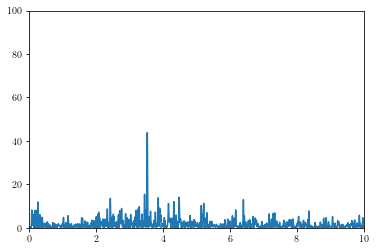

In [5]:
plt.plot(freq,resid)
plt.xlim(0,10)
plt.ylim(0,100)

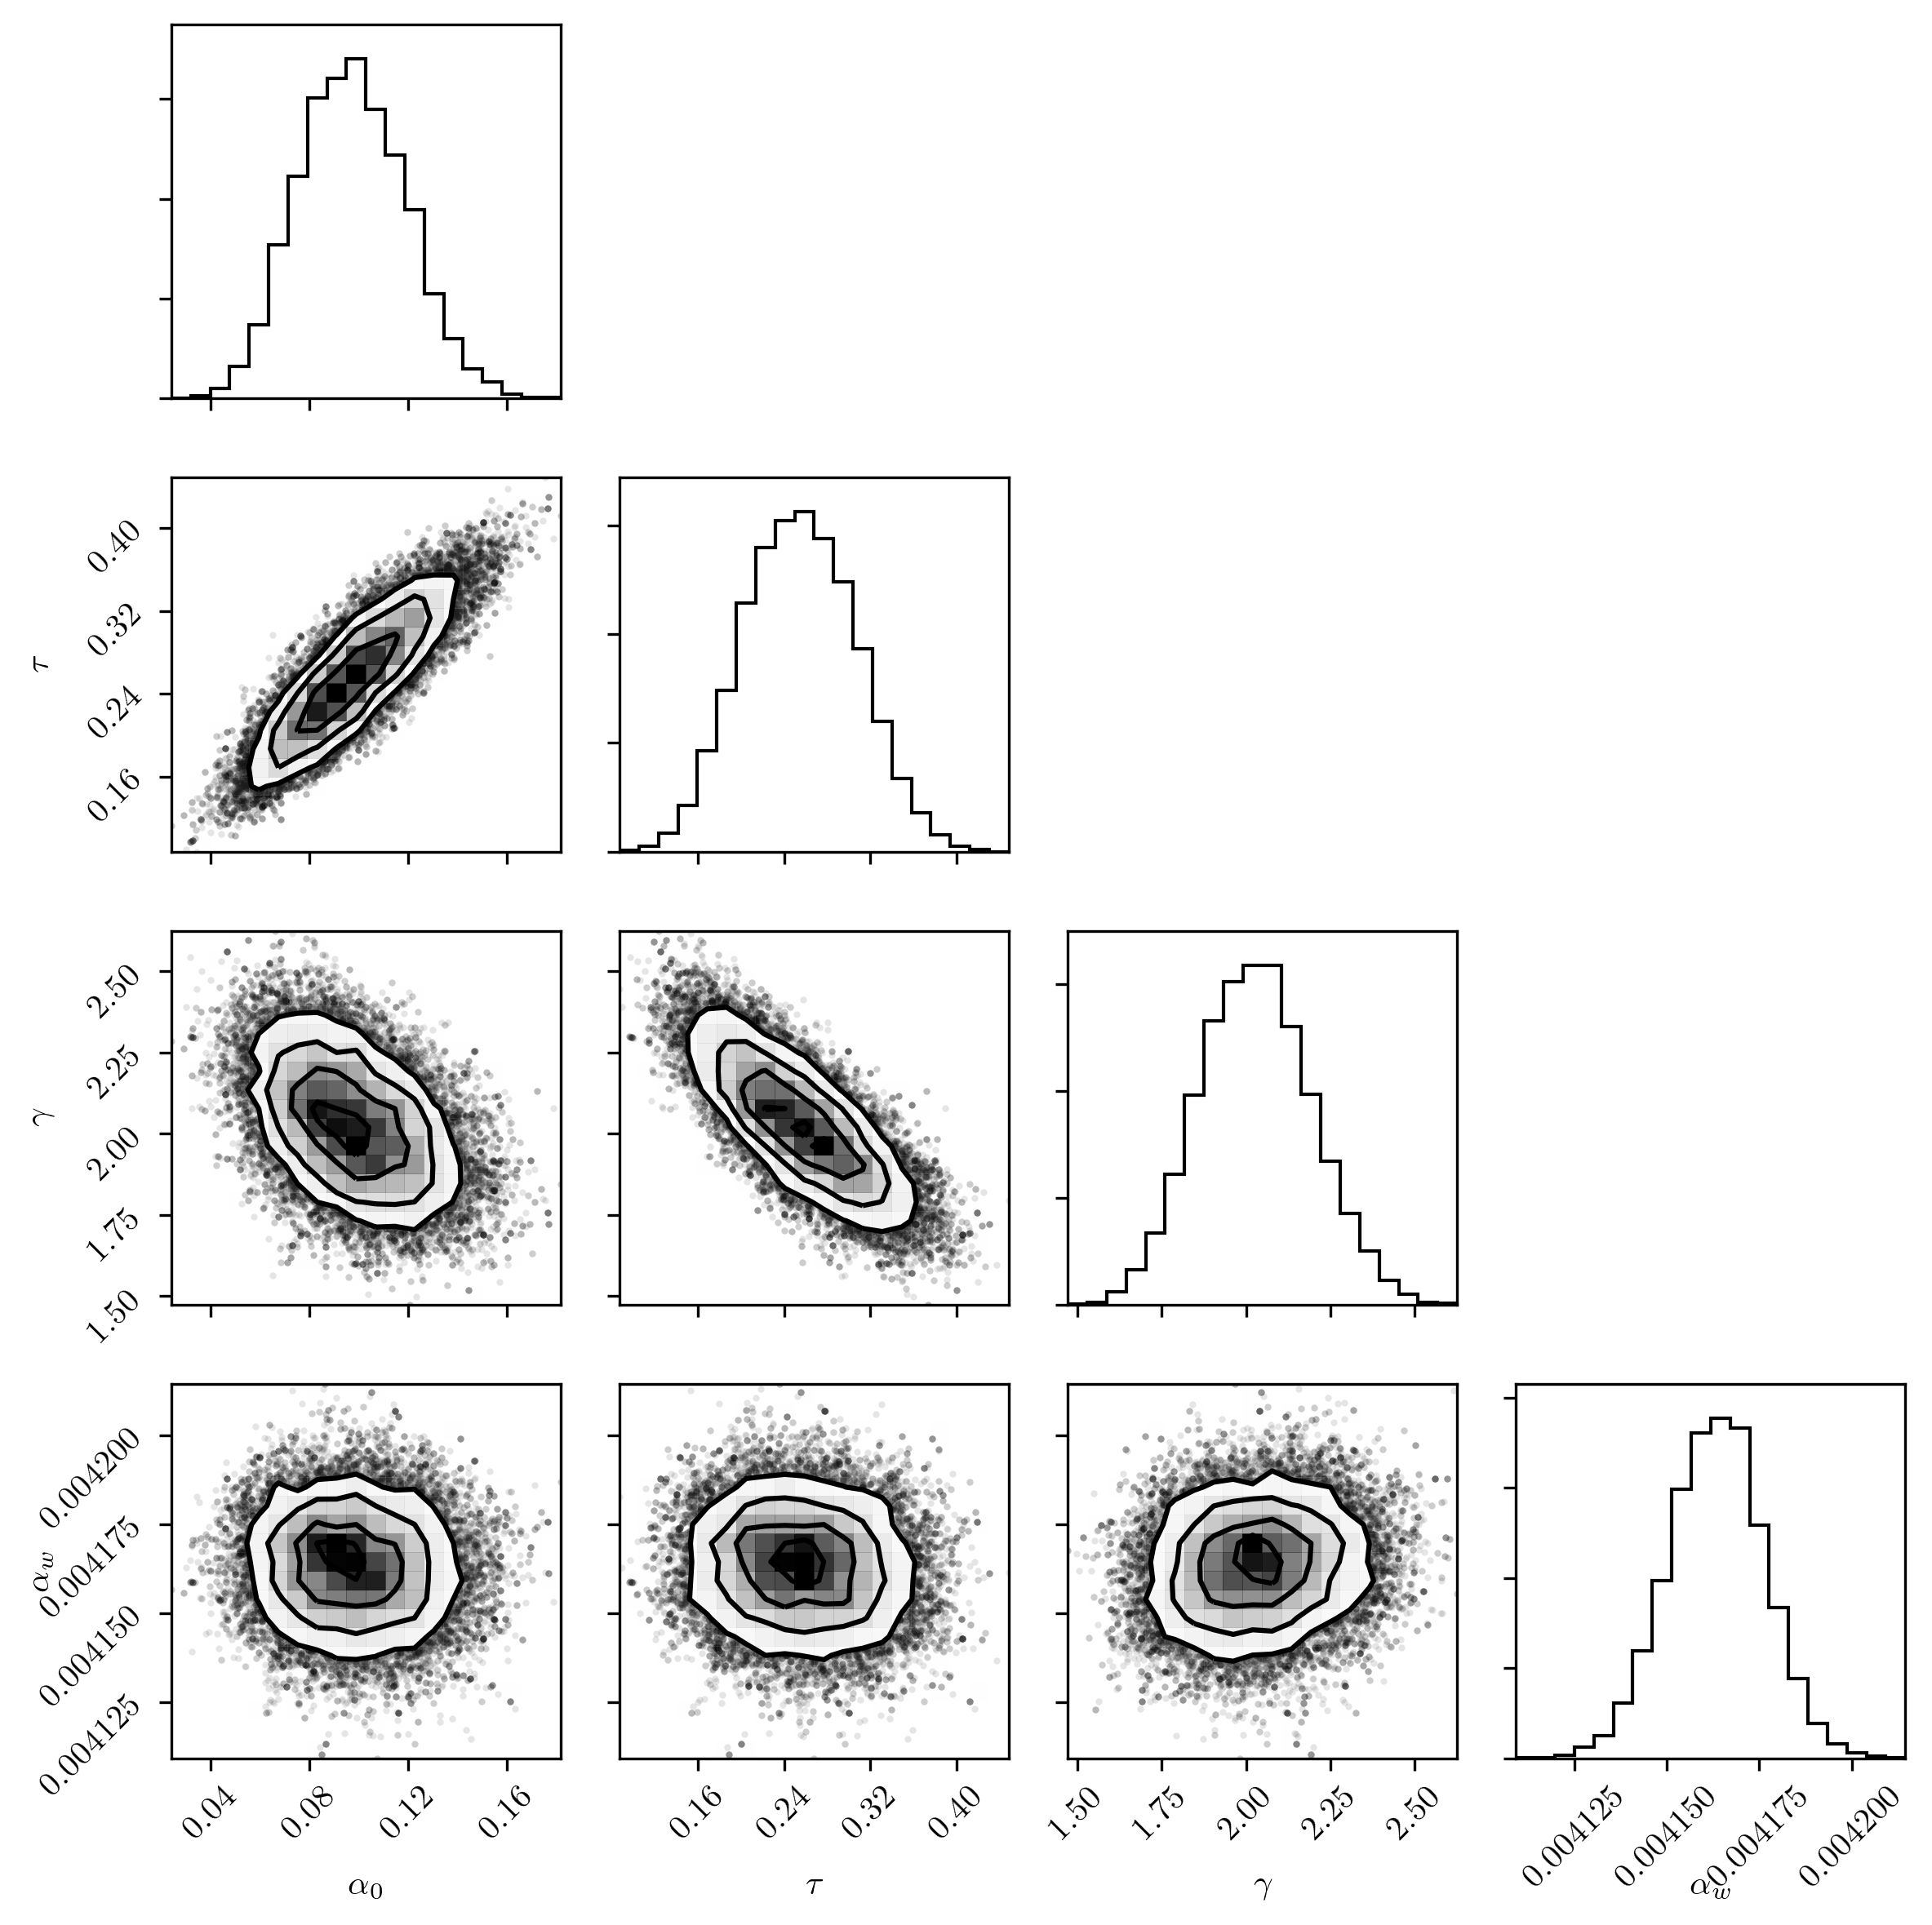

In [6]:
import corner
fig,ax = plt.subplots(4,4,figsize=(8,8),dpi=300)
corner.corner(flat_samples, labels=[r'$\alpha_0$',r'$\tau$',r'$\gamma$',r'$\alpha_w$'],fig=fig)
fig.tight_layout()
plt.savefig('slfv_corner.pdf')

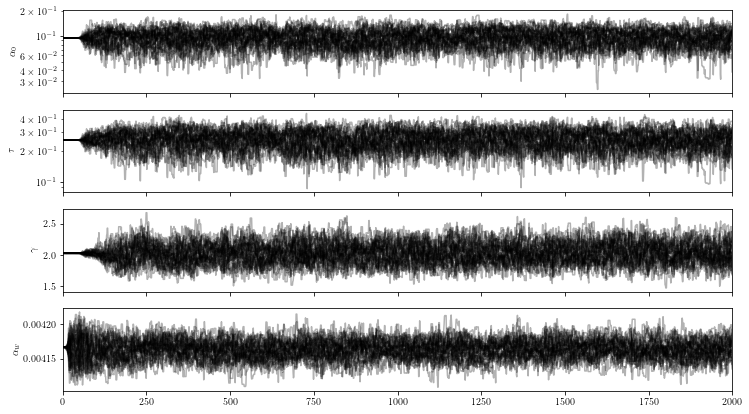

In [7]:
fig, axes = plt.subplots(4, figsize=(12, 7), sharex=True)

samples = sampler.get_chain()
labels = [r'$\alpha_0$',r'$\tau$',r'$\gamma$',r'$\alpha_w$']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    if i < 2:
        ax.set_yscale('log')
    #ax.yaxis.set_label_coords(-0.1, 0.5)

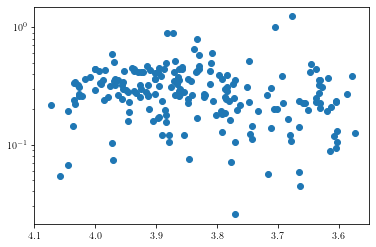

In [8]:
pfoo = np.array(popts)
plt.scatter(cool_sgs['teff'],pfoo[:,1])
plt.xlim(4.1,3.55)
plt.yscale('log')

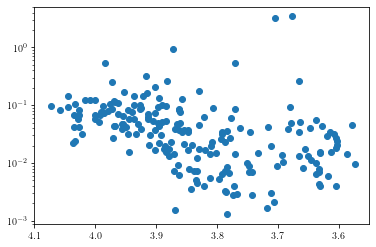

In [9]:
pfoo = np.array(popts)
plt.scatter(cool_sgs['teff'],pfoo[:,0])
plt.xlim(4.1,3.55)
plt.yscale('log')

In [10]:
popts = np.array(popts)
plos = np.array(plos)
phis = np.array(phis)
slfv_result = pd.DataFrame({'alpha':popts[:,0],'alpha_err_lo':popts[:,0]-plos[:,0],'alpha_err_hi':phis[:,0]-popts[:,0],
                           'tau':popts[:,1],'tau_err_lo':popts[:,1]-plos[:,1],'tau_err_hi':phis[:,1]-popts[:,1],
                           'gamma':popts[:,2],'gamma_err_lo':popts[:,2]-plos[:,2],'gamma_err_hi':phis[:,2]-popts[:,2],
                           'alphaw':popts[:,3],'alphaw_err_lo':popts[:,3]-plos[:,3],'alphaw_err_hi':phis[:,3]-popts[:,3]},
                           index=cool_sgs.index)
slfv_result.to_csv('slfv_params.csv')
slfv_result

,alpha,alpha_err_lo,alpha_err_hi,tau,tau_err_lo,tau_err_hi,gamma,gamma_err_lo,gamma_err_hi,alphaw,alphaw_err_lo,alphaw_err_hi
tic,,,,,,,,,,,,
179437520,0.009615,0.000764,0.000771,0.126136,0.013207,0.012928,1.625975,0.067406,0.068952,0.001787,0.000002,0.000002
404965649,0.045711,0.004822,0.004998,0.385658,0.042574,0.044405,1.713333,0.057776,0.054547,0.001792,0.000002,0.000002
40185978,0.014280,0.001384,0.001438,0.270974,0.029321,0.029786,1.938700,0.099979,0.106133,0.001661,0.000002,0.000002
181445828,0.024147,0.005761,0.006113,0.104766,0.025586,0.026246,2.662709,0.581352,0.617187,0.006040,0.000028,0.000028
182735393,0.020608,0.005293,0.005527,0.129572,0.031409,0.031844,3.070555,0.868701,1.022825,0.006129,0.000028,0.000028
...,...,...,...,...,...,...,...,...,...,...,...,...
182730317,0.091992,0.015357,0.016321,0.066408,0.010879,0.010541,2.371536,0.225423,0.245336,0.006435,0.000032,0.000032
180792170,0.142368,0.026355,0.026945,0.194698,0.032911,0.033224,1.973466,0.115030,0.116150,0.004529,0.000015,0.000016
182905190,0.083049,0.009878,0.010121,0.053951,0.006567,0.006352,2.034841,0.110271,0.126873,0.004593,0.000016,0.000016


In [11]:
import h5py as h5
 
j = 0
with h5.File('slfv_trimmed_resids.hdf5','w') as resid_h5:
    for tic,row in cool_sgs.iterrows():
        f = freqs[j]
        r = resids[j]
        grp = resid_h5.create_group(str(tic))
        grp.create_dataset('frequency', data=f)
        grp.create_dataset('residual_power', data=r)
        j += 1

In [9]:
slfv_params = pd.read_csv('slfv_params.csv',index_col=0)
inspected = pd.read_csv('auto_inspected.csv',index_col=0)
merged = pd.merge(cool_sgs,slfv_params,left_index=True,right_index=True)
merged = pd.merge(merged,inspected,left_index=True,right_index=True)
merged

,RA,Dec,dist,pmRA,pmDec,Tmag,ContRatio,SpT,CommonName,MKType,...,gamma_err_hi,alphaw,alphaw_err_lo,alphaw_err_hi,n_peaks,highest_amp,highest_amp_error,f0,f0_error,lc_length
179437520,79.971947,-68.067692,0.091019,1.593040,0.205590,9.8540,NaN,RSG,SV* HV 2450,M1,...,0.068952,0.001787,0.000002,0.000002,1.0,0.000112,0.000004,0.888836,0.000056,353.438659
404965649,85.373961,-69.415872,0.060785,1.788260,0.708052,11.0373,NaN,RSG,CPD-69 502,NaN,...,0.054547,0.001792,0.000002,0.000002,2.0,0.000632,0.000008,0.185827,0.000022,327.866488
40185978,76.968537,-70.434641,0.160504,2.140400,0.216068,11.1070,NaN,RSG,SK -70 80,M0,...,0.106133,0.001661,0.000002,0.000002,2.0,0.000682,0.000007,0.189058,0.000016,353.438654
181445828,13.765720,-73.010260,0.236534,0.797799,-1.265550,11.0965,NaN,YSG,PMMR 74,G6Ia-Iab,...,0.617187,0.006040,0.000028,0.000028,4.0,0.000860,0.000026,0.703227,0.000701,23.854007
182735393,15.655494,-72.273615,0.085619,0.942084,-1.163470,11.1242,NaN,YSG,PMMR 135,G6.5Ia-Iab,...,1.022825,0.006129,0.000028,0.000028,0.0,NaN,NaN,NaN,NaN,23.854045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182730317,16.205624,-72.106040,0.055346,0.664882,-1.272430,11.4480,NaN,YSG,RMC 36,B3:Iak,...,0.245336,0.006435,0.000032,0.000032,5.0,0.004196,0.000065,0.076864,0.000358,23.854054
180792170,12.659946,-73.471738,0.058121,0.543531,-1.243180,11.1544,NaN,YSG,HD 5045,B2:I:,...,0.116150,0.004529,0.000015,0.000016,1.0,0.000226,0.000040,4.052713,0.001974,49.426456
182905190,16.484663,-72.329100,0.057287,0.986675,-1.257930,11.6057,NaN,YSG,LHA 115-S 45,B1.5Ia:,...,0.126873,0.004593,0.000016,0.000016,6.0,0.002484,0.000047,0.189142,0.000212,49.426575
180609595,12.262374,-73.361369,0.051217,0.833683,-1.258340,11.2247,NaN,YSG,HD 4862,B2I,...,0.109677,0.004260,0.000014,0.000014,1.0,0.002578,0.000032,0.181989,0.000140,49.426461


/Users/carina/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/Users/carina/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/carina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


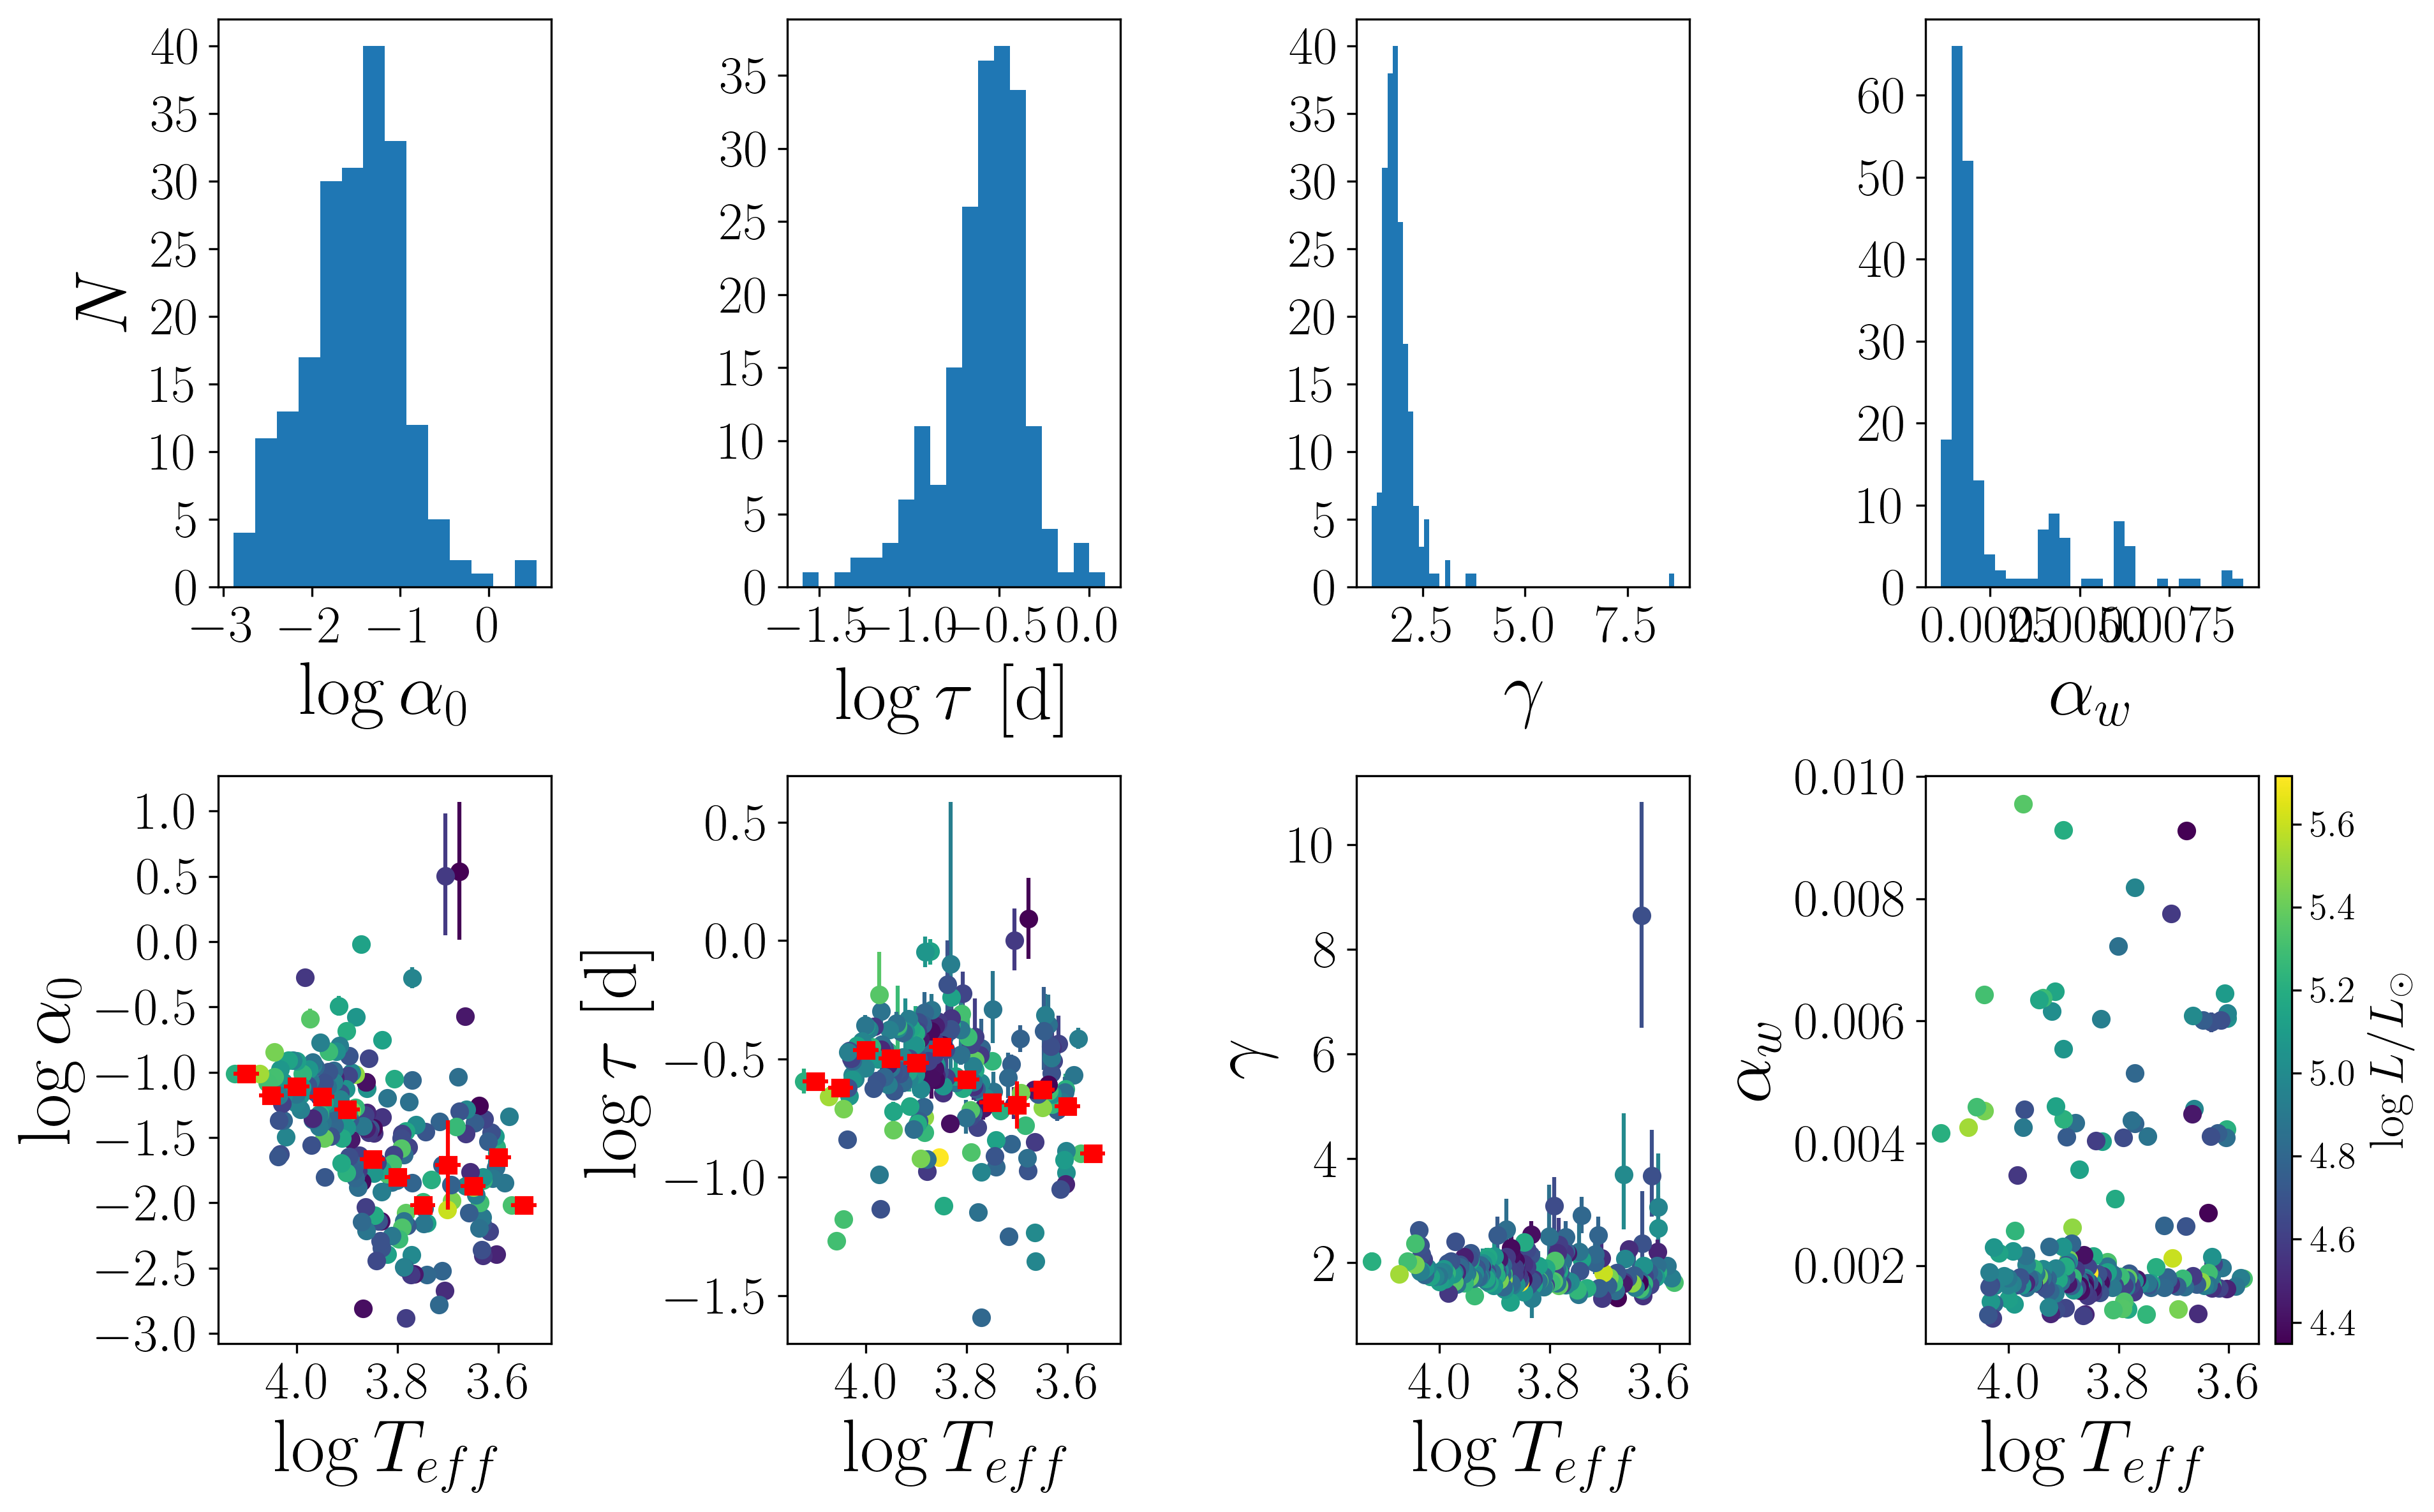

In [4]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import cm, colors
from scipy.stats import sem

#distributions of fit parameters. Only cool thing: RSGs have slope ~2, consistent with... Love? Someone?
fig, axes = plt.subplots(2, 4, figsize=(12,8), dpi=300)
cmap = cm.get_cmap('viridis')
norm = colors.Normalize(vmin=merged['lum'].min(),vmax=merged['lum'].max())

axes[0,0].hist(np.log10(merged['alpha']), bins='auto')
axes[0,1].hist(np.log10(merged['tau']), bins='auto')
axes[0,2].hist(merged['gamma'], bins='auto')
axes[0,3].hist(merged['alphaw'], bins='auto')
for j,star in merged.iterrows():
    if star['gamma'] > 0:
        axes[1,0].errorbar(star['teff'],np.log10(star['alpha']),yerr=[[star['alpha_err_lo']],[star['alpha_err_hi']]],fmt='o',c=cmap(norm(star['lum'])))
        axes[1,1].errorbar(star['teff'],np.log10(star['tau']),yerr=[[star['tau_err_lo']],[star['tau_err_hi']]],fmt='o',c=cmap(norm(star['lum'])))
        axes[1,2].errorbar(star['teff'],star['gamma'],yerr=[[star['gamma_err_lo']],[star['gamma_err_hi']]],fmt='o',c=cmap(norm(star['lum'])))
        axes[1,3].errorbar(star['teff'],star['alphaw'],yerr=[[star['alphaw_err_lo']],[star['alphaw_err_hi']]],fmt='o',c=cmap(norm(star['lum'])))
    
foo = merged.loc[:,['teff','tau','alpha']]
foo['modteff'] = 2.0*foo['teff'].values
gr = foo.groupby(foo['modteff'].round(1))

medtau = gr['tau'].median()
semtau = [sem(merged.loc[x]['tau'].values) for x in gr.groups.values()]
axes[1,1].errorbar(medtau.index.values/2.0,np.log10(medtau.values),fmt='sr',xerr=0.025,yerr=semtau,zorder=10)

medalpha = gr['alpha'].median()
semalpha = [sem(merged.loc[x]['alpha'].values) for x in gr.groups.values()]
axes[1,0].errorbar(medalpha.index.values/2.0,np.log10(medalpha.values),fmt='sr',xerr=0.025,yerr=semalpha,zorder=10)
    
axes[0,0].set(xlabel=r'$\log\alpha_0$',ylabel='$N$')
axes[0,1].set(xlabel=r'$\log\tau$ [d]')
axes[0,2].set(xlabel=r'$\gamma$')
axes[0,3].set(xlabel=r'$\alpha_w$')

axes[1,0].set(xlabel=r'$\log{T_{eff}}$',ylabel=r'$\log\alpha_0$')
axes[1,1].set(xlabel=r'$\log{T_{eff}}$',ylabel=r'$\log\tau$ [d]')
axes[1,2].set(xlabel=r'$\log{T_{eff}}$',ylabel=r'$\gamma$')
axes[1,3].set(xlabel=r'$\log{T_{eff}}$',ylabel=r'$\alpha_w$')

axins = inset_axes(axes[1,3],
                   width="5%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 100%
                   loc='lower left',
                   bbox_to_anchor=(1.05, 0., 1, 1),
                   bbox_transform=axes[1,3].transAxes,
                   borderpad=0,
                   )

cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),cax=axins,orientation='vertical',pad=0.2)
cbar.set_label('$\log L/L_{\odot}$',fontsize=18)
cbar.ax.tick_params(labelsize=14)

for ax in axes.flatten():
    ax.xaxis.label.set_size(28)
    ax.yaxis.label.set_size(28)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(20)
        
for ax in axes[1,:]:
    ax.invert_xaxis()

plt.tight_layout()

#plt.savefig('../plots/fit_params.pdf',bbox_inches='tight')

/Users/carina/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/Users/carina/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/carina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


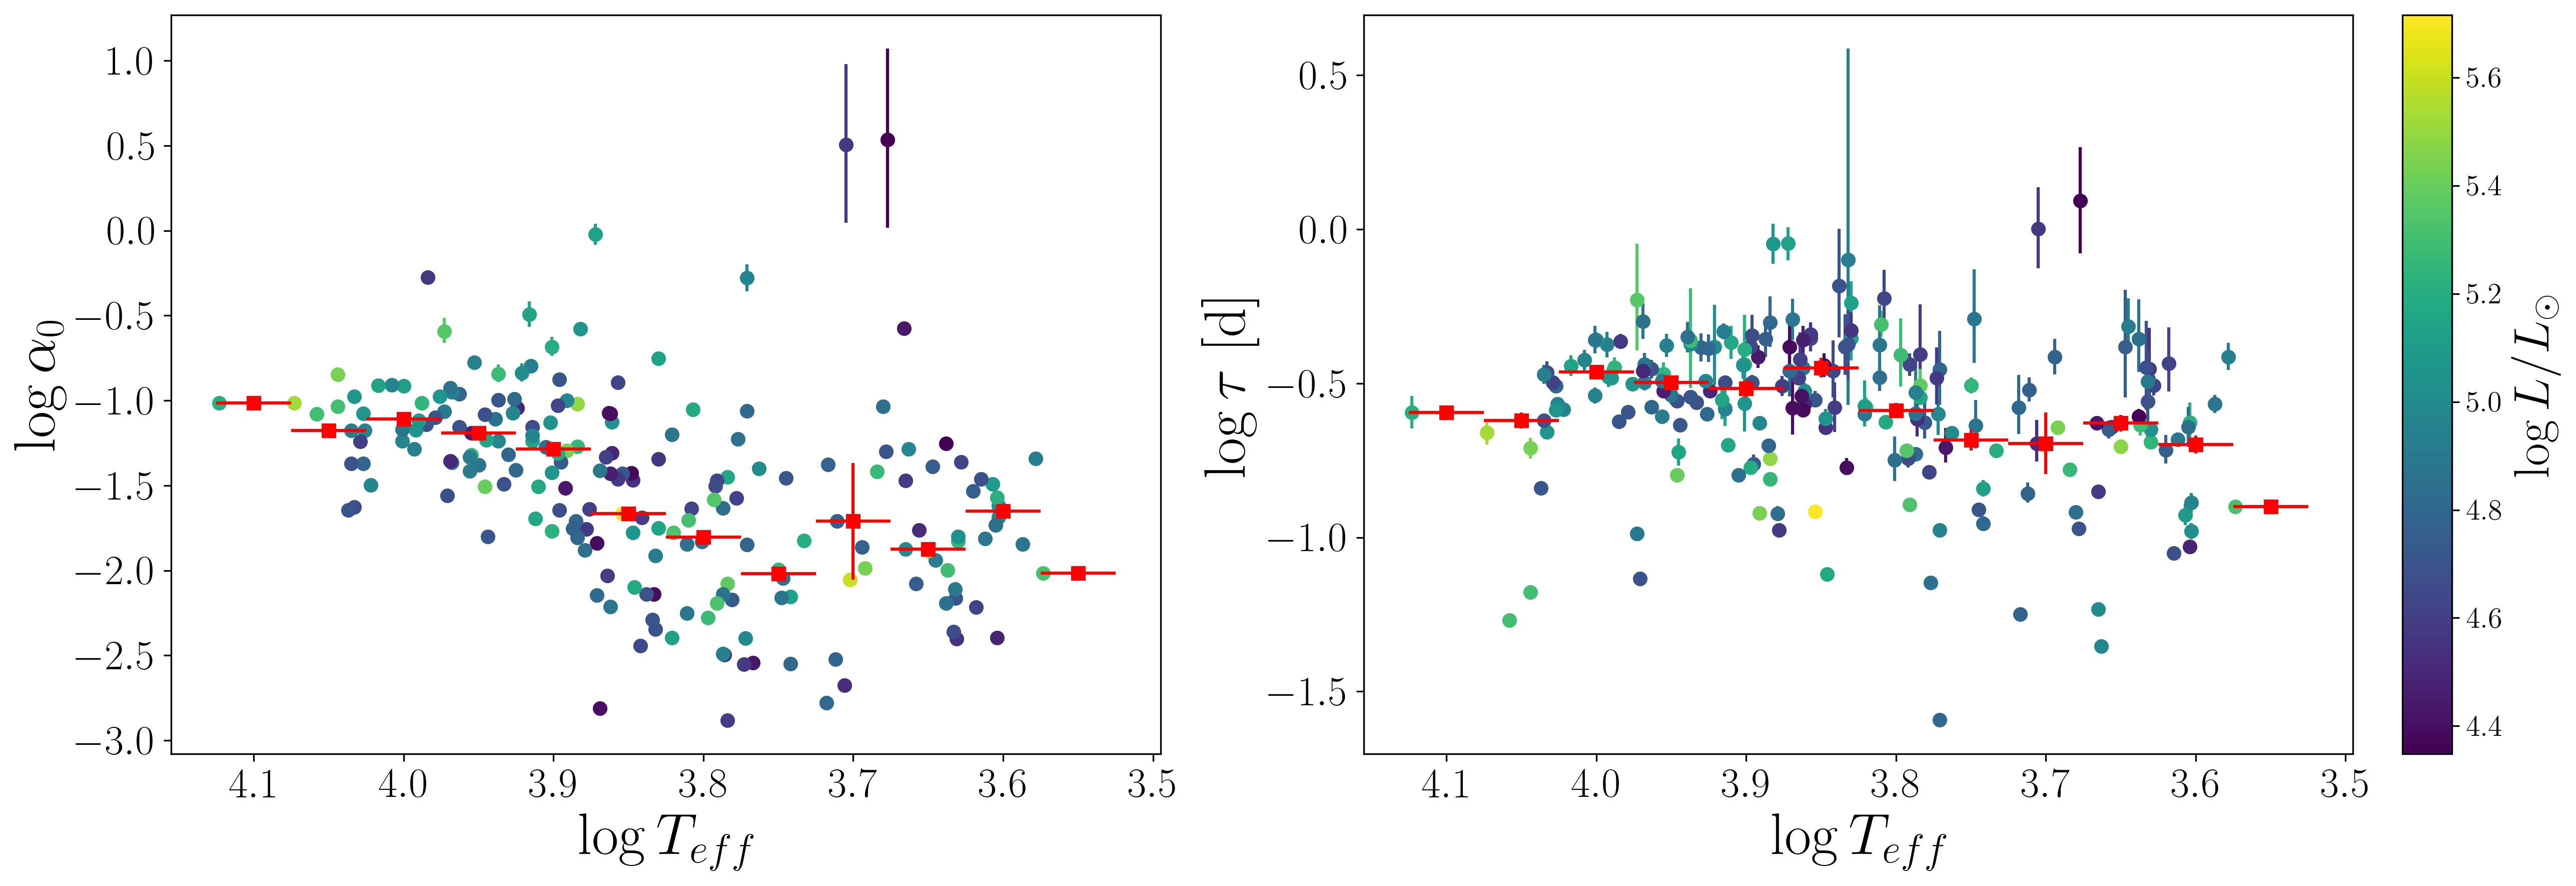

In [5]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import cm, colors
from scipy.stats import sem

#distributions of fit parameters. Only cool thing: RSGs have slope ~2, consistent with... Love? Someone?
fig, axes = plt.subplots(1, 2, figsize=(16,6), dpi=300)
cmap = cm.get_cmap('viridis')
norm = colors.Normalize(vmin=merged['lum'].min(),vmax=merged['lum'].max())

for j,star in merged.iterrows():
    if star['gamma'] > 0:
        axes[0].errorbar(star['teff'],np.log10(star['alpha']),yerr=[[star['alpha_err_lo']],[star['alpha_err_hi']]],fmt='o',c=cmap(norm(star['lum'])))
        axes[1].errorbar(star['teff'],np.log10(star['tau']),yerr=[[star['tau_err_lo']],[star['tau_err_hi']]],fmt='o',c=cmap(norm(star['lum'])))
        
foo = merged.loc[:,['teff','tau','alpha']]
foo['modteff'] = 2.0*foo['teff'].values
gr = foo.groupby(foo['modteff'].round(1))

medtau = gr['tau'].median()
semtau = [sem(merged.loc[x]['tau'].values) for x in gr.groups.values()]
axes[1].errorbar(medtau.index.values/2.0,np.log10(medtau.values),fmt='sr',xerr=0.025,yerr=semtau,zorder=10)

medalpha = gr['alpha'].median()
semalpha = [sem(merged.loc[x]['alpha'].values) for x in gr.groups.values()]
axes[0].errorbar(medalpha.index.values/2.0,np.log10(medalpha.values),fmt='sr',xerr=0.025,yerr=semalpha,zorder=10)

axes[0].set(xlabel=r'$\log{T_{eff}}$',ylabel=r'$\log\alpha_0$')
axes[1].set(xlabel=r'$\log{T_{eff}}$',ylabel=r'$\log\tau$ [d]')

axins = inset_axes(axes[1],
                   width="5%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 100%
                   loc='lower left',
                   bbox_to_anchor=(1.05, 0., 1, 1),
                   bbox_transform=axes[1].transAxes,
                   borderpad=0,
                   )

cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),cax=axins,orientation='vertical',pad=0.2)
cbar.set_label('$\log L/L_{\odot}$',fontsize=24)
cbar.ax.tick_params(labelsize=14)

for ax in axes.flatten():
    ax.xaxis.label.set_size(28)
    ax.yaxis.label.set_size(28)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(20)
        
for ax in axes:
    ax.invert_xaxis()

plt.tight_layout()

plt.savefig('../plots/alpha_tau_teff.pdf',bbox_inches='tight')

In [13]:
# Grab stars where we can extract a frequency with >5 sigma
pulse_detected = merged[(merged['n_peaks'] > 0) & (merged['highest_amp']/merged['highest_amp_error'] > 5)]
print(len(pulse_detected),len(merged))

# Load in info on which stars are consistent with RR Lyrae and Beta Cepheids...
likely_rrcep = pd.read_csv('likelyRRCep.csv',index_col=0)
likely_bcep = pd.read_csv('likelyBCep.csv',index_col=0)
contaminants = pd.merge(likely_rrcep,likely_bcep,left_index=True,right_index=True)

new = pd.merge(pulse_detected,contaminants,left_index=True,right_index=True)
pulse_clean = new[(~new['LikelyRR'])&(~new['LikelyCep'])&(~new['LikelyBCep'])]
no_pulse = merged[~merged.index.isin(pulse_clean.index)]
print(len(pulse_clean),len(no_pulse))

155 201
111 90


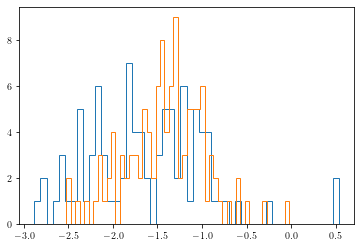

In [22]:
plt.hist(np.log10(no_pulse['alpha']),bins=50,histtype='step')
plt.hist(np.log10(pulse_clean['alpha']),bins=50,histtype='step');

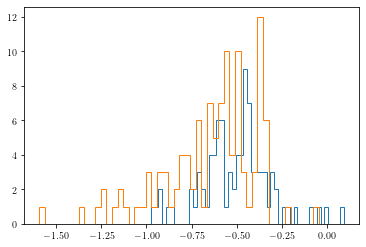

In [23]:
plt.hist(np.log10(no_pulse['tau']),bins=50,histtype='step')
plt.hist(np.log10(pulse_clean['tau']),bins=50,histtype='step');

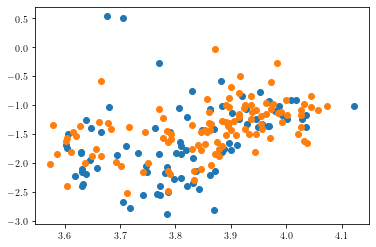

In [24]:
plt.scatter(no_pulse['teff'],np.log10(no_pulse['alpha']))
plt.scatter(pulse_clean['teff'],np.log10(pulse_clean['alpha']))

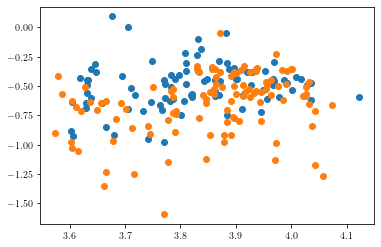

In [25]:
plt.scatter(no_pulse['teff'],np.log10(no_pulse['tau']))
plt.scatter(pulse_clean['teff'],np.log10(pulse_clean['tau']))

In [26]:
def fyps_box(df):
    """
    Returns part of dataframe where teff and lum are in the FYPS box
    """
    
    tmin = df['teff'] >= 3.6
    tmax = df['teff'] <= 4.125
    lmax = df['lum'] <= 7.76 - 0.6*df['teff']
    lmin = df['lum'] >= 6.23 - 0.3*df['teff']
    
    return tmin & tmax & lmax & lmin

candidate_fyps = pulse_clean[fyps_box(pulse_clean)]
all_in_box = merged[fyps_box(merged)]
len(candidate_fyps), len(all_in_box), len(candidate_fyps)/len(all_in_box)

(29, 47, 0.6170212765957447)

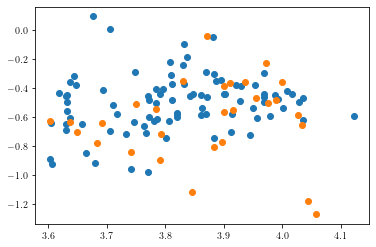

In [27]:
plt.scatter(no_pulse['teff'],np.log10(no_pulse['tau']))
plt.scatter(candidate_fyps['teff'],np.log10(candidate_fyps['tau']))

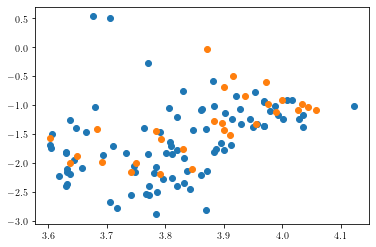

In [28]:
plt.scatter(no_pulse['teff'],np.log10(no_pulse['alpha']))
plt.scatter(candidate_fyps['teff'],np.log10(candidate_fyps['alpha']))

/Users/carina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


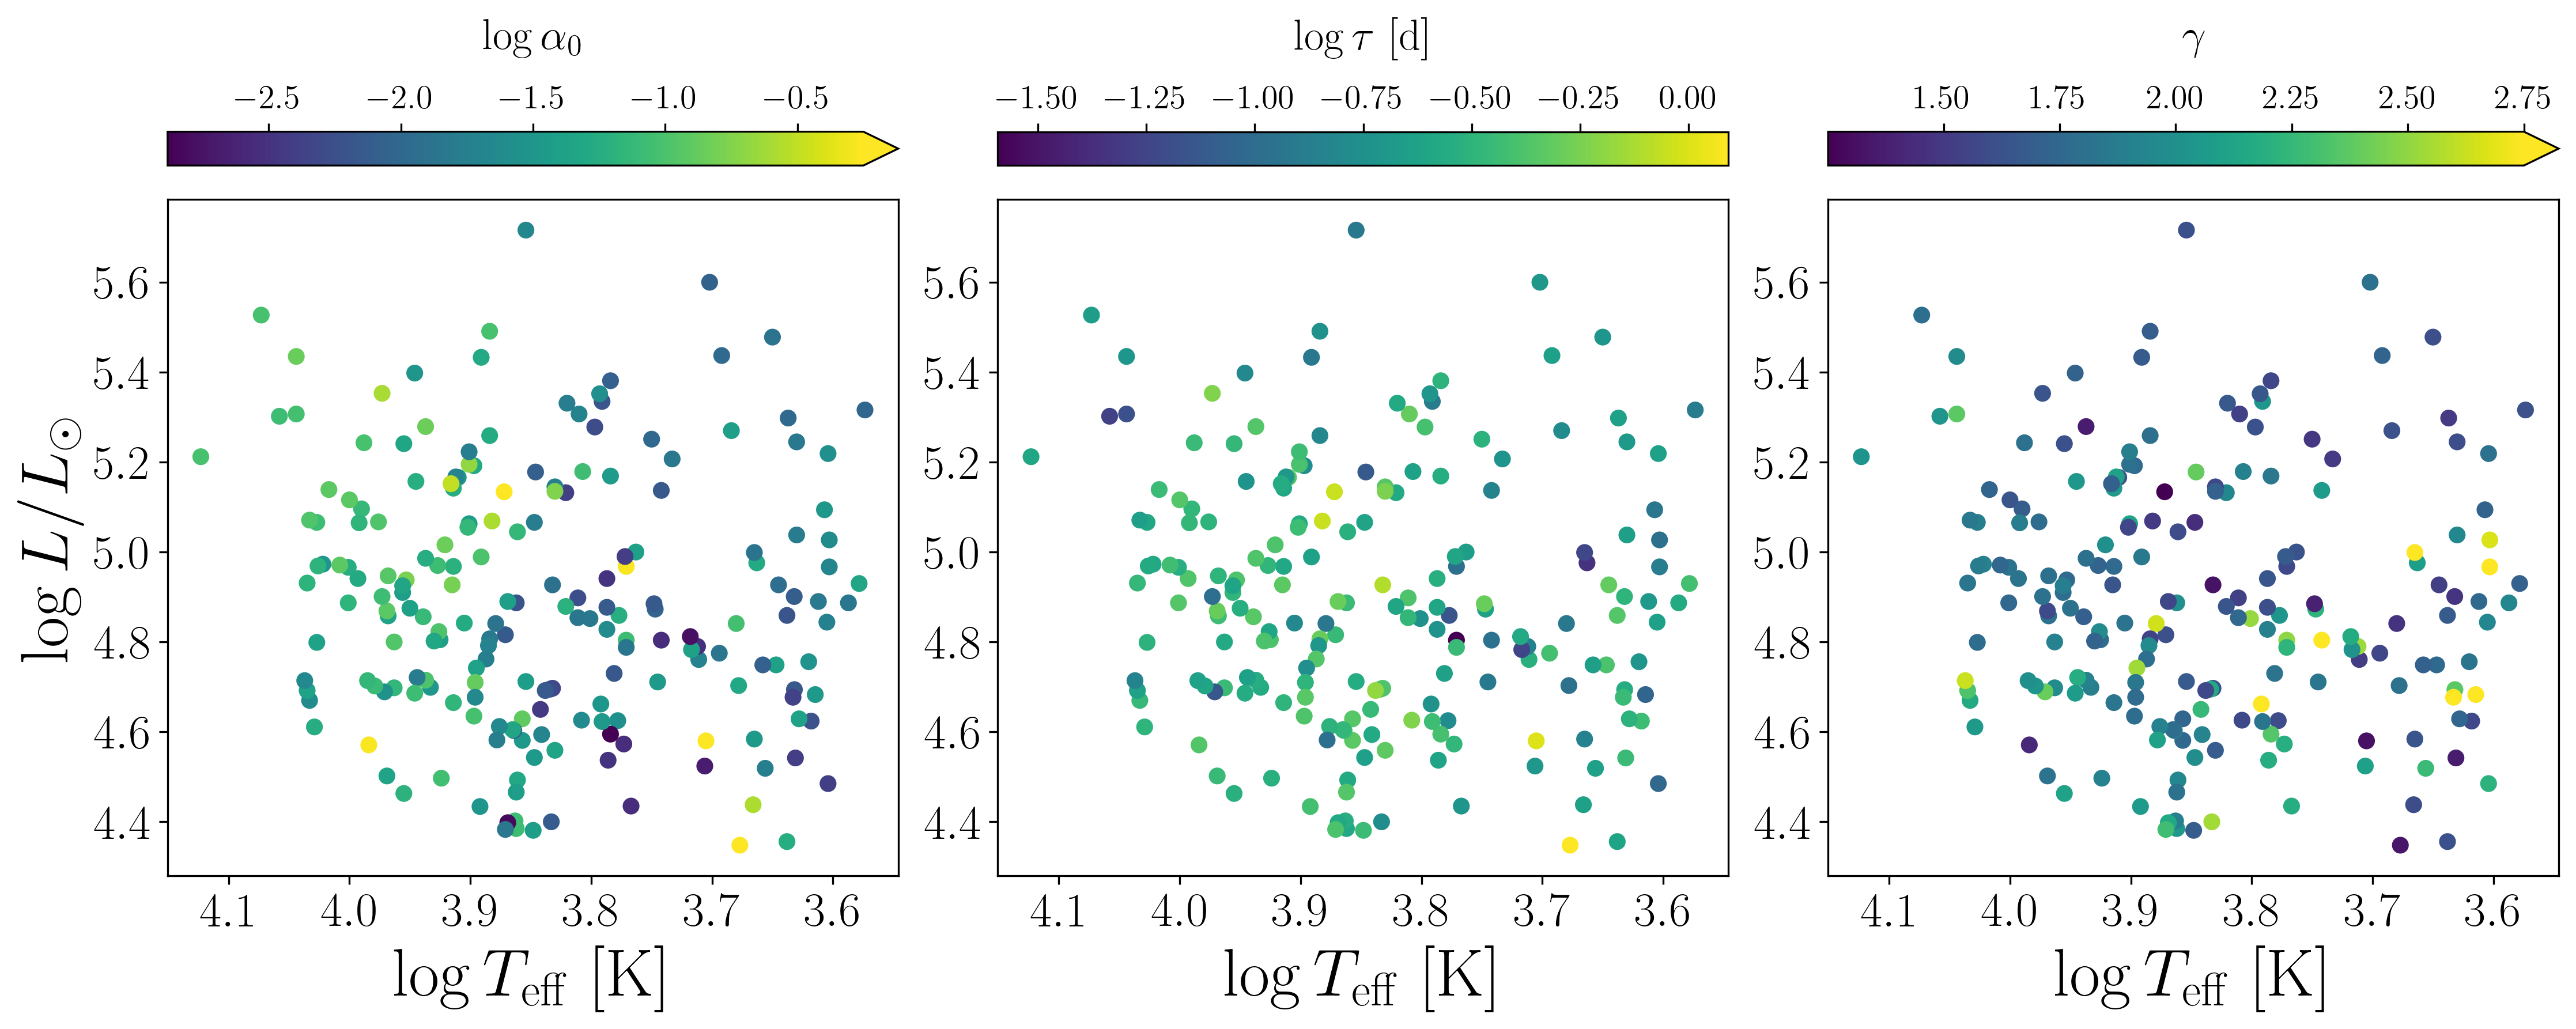

In [15]:
fig, ax = plt.subplots(1,3,figsize=(15,5),dpi=300)
cmap = cm.get_cmap('viridis')

for a,var,lab in zip(ax,['alpha','tau','gamma'],[r'$\log\alpha_0$',r'$\log\tau$ [d]',r'$\gamma$']):
    if var == 'tau':
        car = np.log10(merged[var])
        norm = colors.Normalize(vmin=car.min(),vmax=car.max())
        extend = 'neither'
    elif var == 'alpha':
        car = np.log10(merged[var])
        norm = colors.Normalize(vmin=car.min(),vmax=-0.25)
        extend = 'max'
    else:
        car = merged[var]
        norm = colors.Normalize(vmin=car.min(),vmax=2.75)
        extend = 'max'
    
    a.scatter(merged['teff'],merged['lum'],c=cmap(norm(car)))
    
    axins = inset_axes(a,
                   width="100%",  # width = 5% of parent_bbox width
                   height="5%",  # height : 100%
                   loc='lower left',
                   bbox_to_anchor=(0.0, 1.05, 1, 1),
                   bbox_transform=a.transAxes,
                   borderpad=0,
                   )

    cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),cax=axins,extend=extend,orientation='horizontal',pad=0.2)
    axins.xaxis.set_ticks_position('top')
    axins.xaxis.set_label_position('top')
    cbar.set_label(lab,fontsize=18,labelpad=15)
    cbar.ax.tick_params(labelsize=14)
    
    a.invert_xaxis()
    a.set_xlabel(r'$\log T_{\rm eff}$ [K]')
ax[0].set_ylabel(r'$\log L/L_\odot$')
for a in ax:
    a.xaxis.label.set_size(28)
    a.yaxis.label.set_size(28)
    for tick in a.xaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    for tick in a.yaxis.get_major_ticks():
        tick.label.set_fontsize(20)
fig.tight_layout()

# ~~emcee is being weird, let's try PyMC3/Theano/Exoplanet~~ nevermind, figured it out...

In [7]:
import pymc3 as pm
import theano.tensor as tt
#from exoplanet.gp import terms, GP
#from exoplanet import estimate_inverse_gamma_parameters
#import exoplanet as xo

In [8]:
popts = []
plos = []
phis = []
freqs = []
resids = []

nwalkers=32
burnin=500
production=1000

#os.environ["OMP_NUM_THREADS"] = "1"
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for j,star in cool_sgs.iterrows():#tqdm(cool_sgs.iterrows(), total=len(cool_sgs)):
        tic = j
        lc, lc_smooth = lc_extract(get_lc_from_id(tic), smooth=128)
        time, flux, err = lc['Time'], lc['Flux'], lc['Err']
        pseudo_NF = 0.5 / (np.mean(np.diff(time)))
        ls = LombScargle(time,flux,dy=err)
        freq,power=ls.autopower(normalization='psd')
        power /= len(time) #correct units
        
        amplitude = np.sqrt(power)
    
        good_f = ~np.isnan(freq) & (freq < pseudo_NF)
        good_a = ~np.isnan(np.log10(amplitude))
    
        good_x = freq[good_f & good_a]
        good_y = amplitude[good_a & good_f]
        
        good_x = good_x[::5] #Really gonna speed things up on this one...
        good_y = good_y[::5]
        
        try:
            initial, cov, _ = fit_red_noise(freq, power)
        except RuntimeError:
            initial, cov, _ = fit_red_noise(freq[freq < 50], power[freq < 50])
            
        std = np.sqrt(np.diag(cov))
        
        with pm.Model() as model:
            #half_flat = pm.HalfFlat('hf')
            a0 = pm.Normal(r'$\alpha_0$', mu=initial[0], sd = 2.0*std[0]) #* half_flat
            tau = pm.Normal(r'$\tau$', mu=initial[1], sd = 2.0*std[1])
            gamma = pm.Normal(r'$\gamma$', mu=initial[2], sd = 2.0*std[2])
            aw = pm.Normal(r'$\alpha_w$', mu=initial[3], sd = 2.0*std[3])            
            
            #Likelihood function
            pm.Normal('obs',
                      mu = pm.math.log((a0 / (1.0 + ((2.0*np.pi*tau*good_x) ** gamma))) + aw), 
                      sd = 1.0,
                      observed = pm.math.log(good_y))
            
            map_estimate = pm.find_MAP()
            
            for RV in model.basic_RVs:
                print(RV.name, RV.logp(model.test_point))
                      
            trace = pm.sample(draws=production, tune=burnin, chains=2, cores=4, start=map_estimate, init='advi_map')
        break

logp = -83,645, ||grad|| = 5.4403e+05: 100%|██████████| 3/3 [00:00<00:00, 183.11it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...


$\alpha_0$ 6.475516884847231
$\tau$ 3.790808971741601
$\gamma$ 1.9592926629823677
$\alpha_w$ 12.188780831462266
obs -83669.74580053332


logp = -83,645, ||grad|| = 5.4403e+05: 100%|██████████| 3/3 [00:00<00:00, 157.82it/s]
INFO (theano.gof.compilelock): Refreshing lock /Users/carina/.theano/compiledir_Darwin-19.6.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
ERROR (theano.gof.opt): Optimization failure due to: constant_folding
ERROR (theano.gof.opt): node: Elemwise{true_div,no_inplace}(TensorConstant{(1, 1) of -1.0}, TensorConstant{(1, 1) of 1.0})
ERROR (theano.gof.opt): TRACEBACK:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/Users/carina/anaconda3/lib/python3.7/site-packages/theano/gof/opt.py", line 2034, in process_node
    replacements = lopt.transform(node)
  File "/Users/carina/anaconda3/lib/python3.7/site-packages/theano/tensor/opt.py", line 6516, in constant_folding
    no_recycling=[], impl=impl)
  File "/Users/carina/anaconda3/lib/python3.7/site-packages/theano/gof/op.py", line 955, in make_thunk
    no_recycling)
  File "/Users/carina/anaconda3/lib/python3.7/site-packages/theano/gof/op


You can find the C code in this temporary file: /var/folders/5y/xylgmkx93wg65h8btmx50vn80000gn/T/theano_compilation_error_ohlflp06

You can find the C code in this temporary file: /var/folders/5y/xylgmkx93wg65h8btmx50vn80000gn/T/theano_compilation_error_f3ktrn6v


Exception: ('The following error happened while compiling the node', Elemwise{Composite{((i0 * i1) + i2)}}(InplaceDimShuffle{x,0}.0, Rebroadcast{0}.0, InplaceDimShuffle{x,0}.0), '\n', "Compilation failed (return status=1): /Users/carina/.theano/compiledir_Darwin-19.6.0-x86_64-i386-64bit-i386-3.7.4-64/tmpzcg30h6_/mod.cpp:668:27: error: non-constant-expression cannot be narrowed from type 'npy_intp' (aka 'long') to 'int' in initializer list [-Wc++11-narrowing].     int init_totals[2] = {V5_n0, V3_n1};.                           ^~~~~. /Users/carina/.theano/compiledir_Darwin-19.6.0-x86_64-i386-64bit-i386-3.7.4-64/tmpzcg30h6_/mod.cpp:668:27: note: insert an explicit cast to silence this issue.     int init_totals[2] = {V5_n0, V3_n1};.                           ^~~~~.                           static_cast<int>( ). /Users/carina/.theano/compiledir_Darwin-19.6.0-x86_64-i386-64bit-i386-3.7.4-64/tmpzcg30h6_/mod.cpp:668:34: error: non-constant-expression cannot be narrowed from type 'npy_intp' (aka 'long') to 'int' in initializer list [-Wc++11-narrowing].     int init_totals[2] = {V5_n0, V3_n1};.                                  ^~~~~. /Users/carina/.theano/compiledir_Darwin-19.6.0-x86_64-i386-64bit-i386-3.7.4-64/tmpzcg30h6_/mod.cpp:668:34: note: insert an explicit cast to silence this issue.     int init_totals[2] = {V5_n0, V3_n1};.                                  ^~~~~.                                  static_cast<int>( ). /Users/carina/.theano/compiledir_Darwin-19.6.0-x86_64-i386-64bit-i386-3.7.4-64/tmpzcg30h6_/mod.cpp:680:12: error: non-constant-expression cannot be narrowed from type 'ssize_t' (aka 'long') to 'int' in initializer list [-Wc++11-narrowing].         0, V3_stride1, .            ^~~~~~~~~~. /Users/carina/.theano/compiledir_Darwin-19.6.0-x86_64-i386-64bit-i386-3.7.4-64/tmpzcg30h6_/mod.cpp:680:12: note: insert an explicit cast to silence this issue.         0, V3_stride1, .            ^~~~~~~~~~.            static_cast<int>( ). /Users/carina/.theano/compiledir_Darwin-19.6.0-x86_64-i386-64bit-i386-3.7.4-64/tmpzcg30h6_/mod.cpp:681:1: error: non-constant-expression cannot be narrowed from type 'ssize_t' (aka 'long') to 'int' in initializer list [-Wc++11-narrowing]. V5_stride0, V5_stride1, . ^~~~~~~~~~. /Users/carina/.theano/compiledir_Darwin-19.6.0-x86_64-i386-64bit-i386-3.7.4-64/tmpzcg30h6_/mod.cpp:681:1: note: insert an explicit cast to silence this issue. V5_stride0, V5_stride1, . ^~~~~~~~~~. static_cast<int>( ). /Users/carina/.theano/compiledir_Darwin-19.6.0-x86_64-i386-64bit-i386-3.7.4-64/tmpzcg30h6_/mod.cpp:681:13: error: non-constant-expression cannot be narrowed from type 'ssize_t' (aka 'long') to 'int' in initializer list [-Wc++11-narrowing]. V5_stride0, V5_stride1, .             ^~~~~~~~~~. /Users/carina/.theano/compiledir_Darwin-19.6.0-x86_64-i386-64bit-i386-3.7.4-64/tmpzcg30h6_/mod.cpp:681:13: note: insert an explicit cast to silence this issue. V5_stride0, V5_stride1, .             ^~~~~~~~~~.             static_cast<int>( ). /Users/carina/.theano/compiledir_Darwin-19.6.0-x86_64-i386-64bit-i386-3.7.4-64/tmpzcg30h6_/mod.cpp:682:4: error: non-constant-expression cannot be narrowed from type 'ssize_t' (aka 'long') to 'int' in initializer list [-Wc++11-narrowing]. 0, V7_stride1, .    ^~~~~~~~~~. /Users/carina/.theano/compiledir_Darwin-19.6.0-x86_64-i386-64bit-i386-3.7.4-64/tmpzcg30h6_/mod.cpp:682:4: note: insert an explicit cast to silence this issue. 0, V7_stride1, .    ^~~~~~~~~~.    static_cast<int>( ). /Users/carina/.theano/compiledir_Darwin-19.6.0-x86_64-i386-64bit-i386-3.7.4-64/tmpzcg30h6_/mod.cpp:683:1: error: non-constant-expression cannot be narrowed from type 'ssize_t' (aka 'long') to 'int' in initializer list [-Wc++11-narrowing]. V1_stride0, V1_stride1. ^~~~~~~~~~. /Users/carina/.theano/compiledir_Darwin-19.6.0-x86_64-i386-64bit-i386-3.7.4-64/tmpzcg30h6_/mod.cpp:683:1: note: insert an explicit cast to silence this issue. V1_stride0, V1_stride1. ^~~~~~~~~~. static_cast<int>( ). /Users/carina/.theano/compiledir_Darwin-19.6.0-x86_64-i386-64bit-i386-3.7.4-64/tmpzcg30h6_/mod.cpp:683:13: error: non-constant-expression cannot be narrowed from type 'ssize_t' (aka 'long') to 'int' in initializer list [-Wc++11-narrowing]. V1_stride0, V1_stride1.             ^~~~~~~~~~. /Users/carina/.theano/compiledir_Darwin-19.6.0-x86_64-i386-64bit-i386-3.7.4-64/tmpzcg30h6_/mod.cpp:683:13: note: insert an explicit cast to silence this issue. V1_stride0, V1_stride1.             ^~~~~~~~~~.             static_cast<int>( ). 8 errors generated.. ", '[Elemwise{Composite{((i0 * i1) + i2)}}(<TensorType(float64, row)>, <TensorType(float64, matrix)>, <TensorType(float64, row)>)]')